In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns


from seism_func import get_well_info, get_seism_cube, seism_vectors, get_seism_index

In [2]:
PATH_TO_WELL_COORD = "../Gis_analise/Proc_well_coord.csv"
PATH_TO_T_TOP = "../Gis_analise/omsk/Well_TOP.csv"
PATH_TO_T_BOTTOM = "seism_data/Well_bottom_time.txt"

WELL_COORD_DEF_SET_INDEX = "Unnamed: 0"
T_TOP_DEF_SET_INDEX = "Well"
T_BOTTOM_DEF_SET_INDEX = "Well identifier"

FILE_NAME_WELLS_INFO = "Wells_info"
FILE_NAME_WELLS_INDEX_SEISM = "Wells_index_seism"

### Формирование и сохранение в файл данных скважин: 

* Kоординаты скважины, 
* Отсечки пласта по метрам и секундам
* Скорость звуковой волны (линеаризованная)

['g274', 'g276', 'g277', 'g278', 'g279', 'g280', 'g281', 'g282', 'g288', 'g291', 'g292', 'g293', 'g294', 'g295', 'g297', 'g299', 'g300', 'g301', 'g309', 'g310', 'g311', 'g314', 'g315', 'g319', 'g320', 'g321', 'g325', 'g326', 'g327', 'g328', 'g329', 'g330', 'g332', 'g334', 'g336', 'g337', 'g338', 'g339', 'g340', 'g341', 'g342', 'g343', 'g345', 'g346', 'g347', 'g348', 'g351', 'g352', 'g353', 'g354', 'g356', 'g358', 'g360', 'g361', 'g362', 'g372', 'g373', 'g375', 'g377', 'g382', 'g384', 'g385', 'g386', 'g387', 'g388', 'g389', 'g397', 'g398', 'g400', 'g401', 'g402', 'g403', 'g407', 'g408', 'g409', 'g410', 'g412', 'g414', 'g422', 'g423', 'g425', 'g432', 'g433', 'g434', 'g435', 'g436', 'g442', 'g443', 'g452', 'g453', 'g455', 'g461', 'g463', 'g464', 'g470', 'g471', 'g472', 'g476', 'g483', 'g489', 'g490', 'g496', 'g498', 'g501', 'g506', 'g507', 'g508', 'g513', 'g514', 'g515', 'g517', 'g518', 'g520', 'g531', 'g532', 'g534', 'g540', 'g541', 'g542', 'g543', 'g544', 'g545', 'g547', 'g549', 'g550',

,x,y,top_z,bottom_z,top_t,bottom_t,delta_z,delta_t,v
Well,,,,,,,,,
g274,531608.23,6421427.75,2952.5,2992.9,-2112.48,-2151,40.4,38.52,2097.611630
g276,530155.25,6413678.34,2886.7,2924.5,-2149.20,-2192,37.8,42.80,1766.355140
g277,530745.09,6413681.03,2844.5,2881.8,-2140.57,-2194,37.3,53.43,1396.219352
g278,530083.39,6413163.24,2818.7,2854.7,-2142.02,-2202,36.0,59.98,1200.400133
g279,530429.23,6413182.18,2780.1,2815.3,-2137.48,-2201,35.2,63.52,1108.312343
...,...,...,...,...,...,...,...,...,...
g556,531097.45,6414599.81,3324.3,3363.0,-2142.59,-2182,38.7,39.41,1963.968536
g557,531556.80,6414379.37,3321.7,3360.5,-2140.13,-2187,38.8,46.87,1655.643269
g558,530704.10,6414130.92,3027.6,3066.0,-2144.22,-2192,38.4,47.78,1607.367099


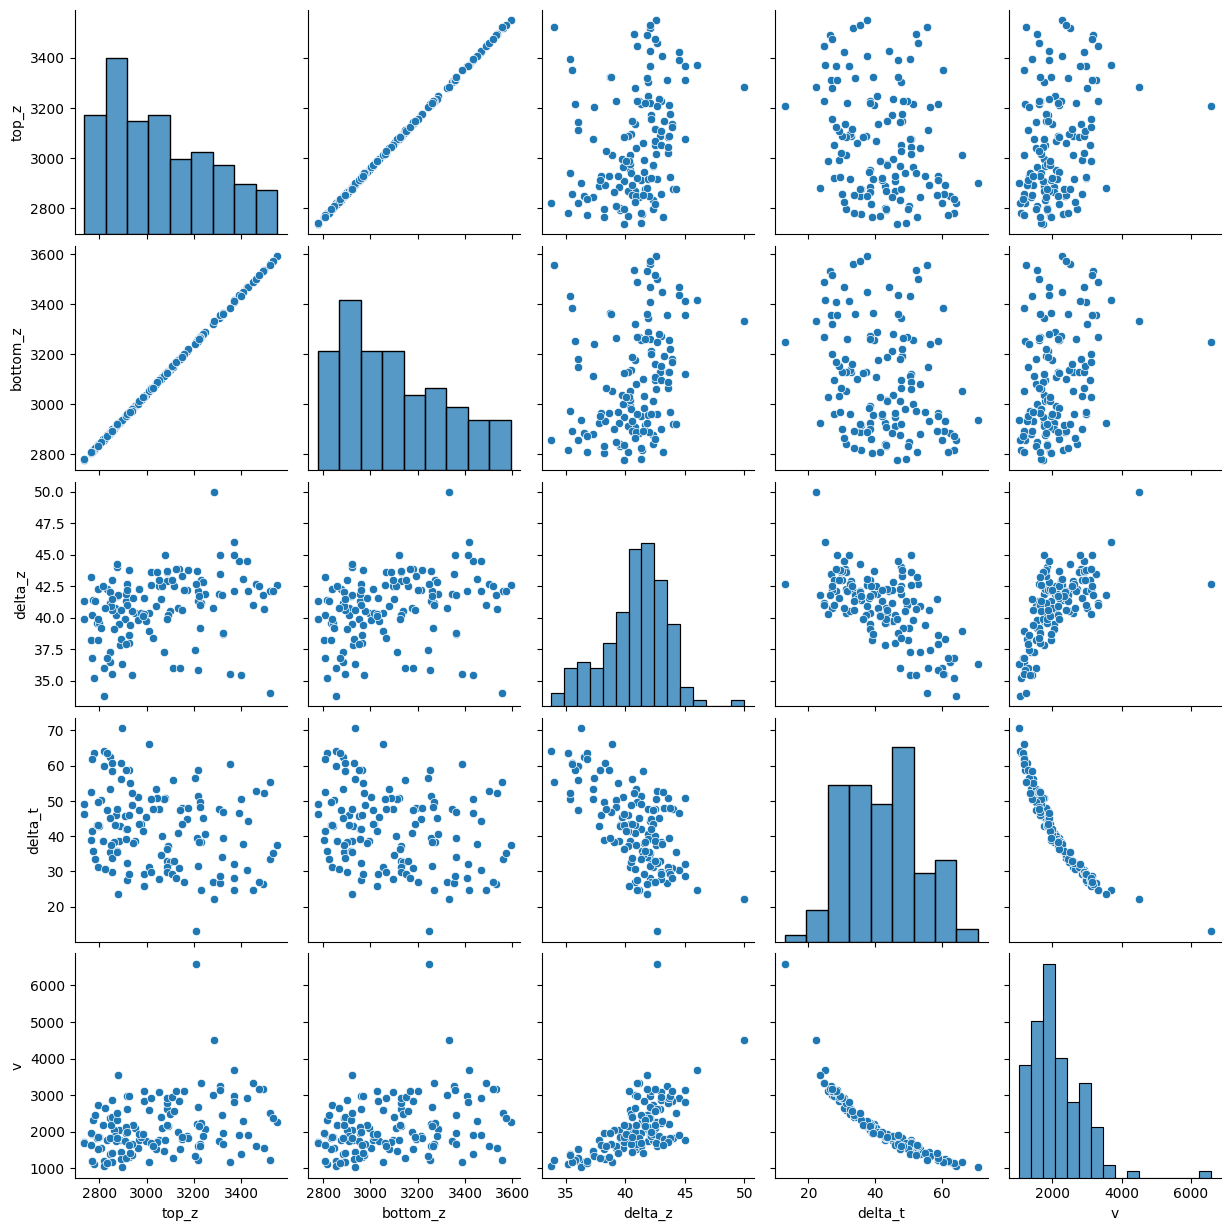

In [3]:
df_info = get_well_info(PATH_TO_WELL_COORD, PATH_TO_T_TOP, PATH_TO_T_BOTTOM, 
                        WELL_COORD_DEF_SET_INDEX, T_TOP_DEF_SET_INDEX, T_BOTTOM_DEF_SET_INDEX)

print(list(df_info.index))

sns.pairplot(df_info[["top_z","bottom_z","delta_z", "delta_t", "v"]])
df_info

In [4]:
df_info[(df_info["v"]>4000)]

,x,y,top_z,bottom_z,top_t,bottom_t,delta_z,delta_t,v
Well,,,,,,,,,
g389,533432.50,6420236.39,3282.6,3332.6,-2115.78,-2138,50.0,22.22,4500.450045
g414,533744.11,6419173.02,3207.1,3249.8,-2109.05,-2122,42.7,12.95,6594.594595


In [ ]:
df_info.loc[]

In [5]:
df_info[["x", "y", "top_z", "bottom_z", "top_t", "bottom_t", "v"]].to_excel(FILE_NAME_WELLS_INFO + ".xlsx")
df_info[["x", "y", "top_z", "bottom_z", "top_t", "bottom_t", "v"]].to_csv(FILE_NAME_WELLS_INFO + ".csv", sep=";")

### Получение данных от сейсмокуба по координатам скважины 

In [6]:
ar_seism = get_seism_cube(file_dir="seism_data")

### Перерасчет секунд в метры

In [7]:
#l_wells = ['g274', 'g276', 'g277', 'g278', 'g279', 'g280', 'g281']
l_wells = list(df_info.index)

ar_x = df_info.loc[l_wells, "x"].to_list()
ar_y = df_info.loc[l_wells, "y"].to_list()
ar_top_z = df_info.loc[l_wells, "top_z"].to_list()
ar_bottom_z = df_info.loc[l_wells, "bottom_z"].to_list()
ar_top_t = df_info.loc[l_wells, "top_t"].to_list()
ar_bottom_t = df_info.loc[l_wells, "bottom_t"].to_list()
ar_v = df_info.loc[l_wells, "v"].to_list()

In [8]:
def seconds2meters(z_cube_len,
                   z_top, 
                   t_top, 
                   v,
                   delta_t=2):
    """ Evaluates indexes for z-values of list of seisma cube.

    z_cube_len - depths of seiama cube
    z_top - top bounds of krovla, podoshva in meters
    t_top - top bounds of krovla, podoshva in mseconds
    v - average velocities of sound
    delta_t - discretisation of depth in mseconds
    """
    # Getting massive of depth values. Suggesting velocity=const.
    z_mult = []
    for z_top_i, t_top_i, v in zip(z_top, t_top, v):
        t = np.arange(0, -z_cube_len*delta_t, -delta_t) 
        z_mult.append( -(t - t_top_i)/2/1000*v + z_top_i )

    z_mult = np.array(z_mult)


    df_index_seism = pd.DataFrame(z_mult.T, columns=l_wells)
    df_index_seism.index.name = "z_m_index"

    return df_index_seism

In [9]:
df_index_seism = seconds2meters(
                 z_cube_len = ar_seism.shape[2],
                 z_top = ar_top_z,
                 v = ar_v,
                 t_top = ar_top_t)

In [10]:
df_index_seism.to_csv(FILE_NAME_WELLS_INDEX_SEISM + ".csv", sep=";")
df_index_seism.to_excel(FILE_NAME_WELLS_INDEX_SEISM + ".xlsx")

### Получение сейсмики для координат соответствующих скважин

In [11]:
matrix_seism, mask = seism_vectors(ar_seism, ar_x, ar_y)

x=531608.23	y=6421427.75	x_index=299	y_index=463	in=True
x=530155.25	y=6413678.34	x_index=239	y_index=148	in=True
x=530745.09	y=6413681.03	x_index=263	y_index=148	in=True
x=530083.39	y=6413163.24	x_index=237	y_index=127	in=True
x=530429.23	y=6413182.18	x_index=251	y_index=128	in=True
x=530170.52	y=6412629.81	x_index=240	y_index=105	in=True
x=530498.72	y=6412393.91	x_index=253	y_index=96	in=True
x=530768.84	y=6412662.08	x_index=264	y_index=107	in=True
x=531191.3	y=6423216.1	x_index=282	y_index=536	in=True
x=530116.19	y=6421675.87	x_index=238	y_index=473	in=True
x=530099.77	y=6421101.49	x_index=237	y_index=450	in=True
x=531933.23	y=6421116.01	x_index=312	y_index=451	in=True
x=530627.21	y=6422569.79	x_index=259	y_index=510	in=True
x=531791.33	y=6422633.11	x_index=306	y_index=512	in=True
x=529555.07	y=6422141.22	x_index=215	y_index=492	in=True
x=528966.29	y=6420065.74	x_index=191	y_index=408	in=True
x=528635.72	y=6424119.45	x_index=178	y_index=573	in=True
x=529208.45	y=6424255.66	x_index=2

In [12]:
df_seism = pd.DataFrame(matrix_seism.T, columns=l_wells)
df_seism.index.name = "z_m_index"

df_seism

,g274,g276,g277,g278,g279,g280,g281,g282,g288,g291,...,g551,g552,g553,g554,g555,g556,g557,g558,g559,g581
z_m_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_seism.to_csv("Wells_seism.csv", sep=";")
df_seism.to_excel("Wells_seism.xlsx")

In [ ]:
color = '33, 35, 231'

fig = go.Figure()
fig.add_trace(go.Scatter(x=z_index, y=z_index))
fig.add_traces([go.Scatter(x = z_index, y = z_index+z_std_index,
                           mode = 'lines', line_color = f'rgba(0,0,0,0)',
                           name = f'up std',
                           showlegend = False),
                        
                go.Scatter(x = z_index, y = z_index-z_std_index,
                           mode = 'lines', line_color = f'rgba(0,0,0,0)',
                           name = f'low std',
                           fill='tonexty', fillcolor = f'rgba({color}, 0.45)',
                           showlegend = False)])

fig.add_trace(go.Scatter(x=[7000, 8000], y=[7000, 8000]))
fig.show()